In [1]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline
import pandas as pd
import numpy as np
import math
import random
from math import atan

## Read image

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

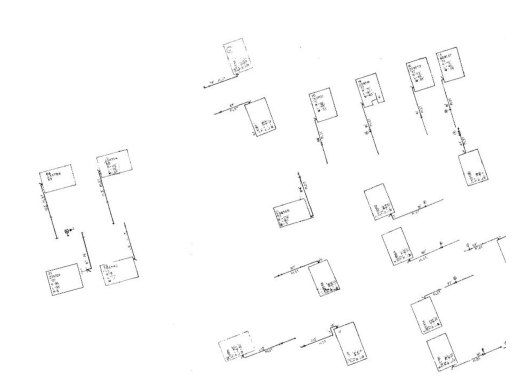

In [2]:
image = cv2.imread('NG (1).jpg')
plt.imshow(image)
plt.axis('off')
print

## Image Preprocessing

In [3]:
img=image.copy()
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)
dilate = cv2.dilate(erosion,kernel,iterations = 1)

In [4]:
gray = cv2.cvtColor(dilate, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 1)
edged = cv2.Canny(gray, 100, 150,apertureSize=3)
edged1 = cv2.dilate(edged,kernel,iterations =1)

In [5]:
cv2.imshow('only', edged1)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Line Detection

In [6]:
img=image.copy()
img1=image.copy()
theta_rho_list =[]
lines_list = []
lines = cv2.HoughLinesP(
            edged1, # Input edge image
            2, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=50, # Min number of votes for valid line
            minLineLength=60, # Min allowed length of line
            maxLineGap=2,# Max allowed gap between line for joining them
            )
  
# Iterate over points
for points in lines:
      # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    theta = np.arctan2(y2 - y1, x2 - x1)
    rho = x1 * np.cos(theta) + y1 * np.sin(theta)
    # Draw the lines joing the points
    # On the original image
    cv2.line(img,(x1,y1),(x2,y2),(0,0,0),2)
    cv2.line(img1,(x1,y1),(x2,y2),(255,255,255),5)
    # Maintain a simples lookup list for points
    theta_rho_list.append([(theta),(rho)])
    lines_list.append([(x1,y1),(x2,y2)])
      

In [7]:
cv2.imshow('only', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Remove duplicate lines in line detection

In [8]:
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def filter_close_lines(lines, distance_threshold):
    filtered_lines = []

    for line_i in lines:
        x1, y1, x2, y2 = line_i[0]
        keep_line_i = True

        for line_j in lines:
            x1_j, y1_j, x2_j, y2_j = line_j[0]
            distance = min(
                calculate_distance((x1, y1), (x1_j, y1_j)),   # Distance between start points
                calculate_distance((x1, y1), (x2_j, y2_j)),   # Distance between start point and end point
                calculate_distance((x2, y2), (x1_j, y1_j)),   # Distance between end point and start point
                calculate_distance((x2, y2), (x2_j, y2_j))    # Distance between end points
            )

            if distance < distance_threshold:
                # Lines are close, decide which one to keep (e.g., keep the longer line)
                line_i_length = calculate_distance((x1, y1), (x2, y2))
                line_j_length = calculate_distance((x1_j, y1_j), (x2_j, y2_j))
                keep_line_i = line_i_length > line_j_length  # Keep the longer line, you can modify this condition based on your needs
                break

        if keep_line_i:
            filtered_lines.append(line_i)

    return filtered_lines


In [9]:
distance_threshold = 3  # Define your distance threshold here
filtered_lines = filter_close_lines(lines, distance_threshold)

In [10]:
filtr=image.copy()
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(filtr, (x1, y1), (x2, y2), (255, 0, 0), 2)

In [11]:
cv2.imshow('only', filtr)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Find perpendicular lines and remove the shorter one

In [25]:

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

def direction(p, q, r):
    return (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)


def areCollinearAndOverlapping(a1, b1, a2, b2):
    if direction(a1, b1, a2) == 0:
        if a2.x <= max(a1.x, b1.x) and a2.x >= min(a1.x, b1.x) and a2.y <= max(a1.y, b1.y) and a2.y >= min(a1.y, b1.y):
            return True
    return False

def isintersect(a1, b1, a2, b2):
    d1 = direction(a1, b1, a2)
    d2 = direction(a1, b1, b2)
    d3 = direction(a2, b2, a1)
    d4 = direction(a2, b2, b1)

    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True

    if areCollinearAndOverlapping(a1, b1, a2, b2) or areCollinearAndOverlapping(a2, b2, a1, b1):
        return True

    return False


In [27]:
def slope(x1, y1, x2, y2):
    if(x2 - x1 != 0):
        return (float)(y2-y1)/(x2-x1)

def findAngle(M1, M2):
    PI = 3.14159265

    angle = abs((M2 - M1) / (1 + M1 * M2))

    ret = atan(angle)

    # radian to degree
    val = (ret * 180) / PI
 
    # Print the result
    return (round(val, 4))

def filter_perpendicular_lines(lines):
    perpendicular_lines = []

    for line_i in lines:
        x1, y1, x2, y2 = line_i[0]
        s1 = slope(x1, y1, x2, y2)
        keep_line_i = True

        for line_j in lines:
            x1_j, y1_j, x2_j, y2_j = line_j[0]
            s2 = slope(x1_j, y1_j, x2_j, y2_j)
            ang = findAngle(s1, s2)
            a1 = Point(x1, y1)
            b1 = Point(x2, y2)
            a2 = Point(x1_j, y1_j)
            b2 = Point(x2_j,y2_j)
            if isintersect(a1,b1,a2,b2):
                if 80 <= ang <= 100 or 260 <= ang <= 280:
                    # Lines are close, decide which one to keep (e.g., keep the longer line)
                    line_i_length = calculate_distance((x1, y1), (x2, y2))
                    line_j_length = calculate_distance((x1_j, y1_j), (x2_j, y2_j))
                    keep_line_i = line_i_length > line_j_length  # Keep the longer line, you can modify this condition based on your needs
                    break

        if keep_line_i:
            perpendicular_lines.append(line_i)

    return perpendicular_lines

In [28]:
perpendicular_lines=filter_perpendicular_lines(filtered_lines)
perp=filtr.copy()
for line in perpendicular_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(perp, (x1, y1), (x2, y2), (0, 255, 0), 2)

In [31]:
cv2.imshow('only', perp)
cv2.waitKey(0)
cv2.destroyAllWindows()


## Contour detection

In [888]:
co = img1.copy()
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(co,kernel,iterations = 2)
dilate = cv2.dilate(erosion,kernel,iterations = 2)

In [889]:
gray = cv2.cvtColor(dilate, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 1)
edged = cv2.Canny(blurred, 10, 100)

In [893]:
contours, hierarchy = cv2.findContours(image=edged, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
image_copy = img.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
cv2.imshow('only', image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()